In [1]:
import sys
sys.path.append("../../BayesFlow")
sys.path.append("../")

import os
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import numpy as np
import pickle

import keras

In [2]:
import bayesflow as bf
from dmc import DMC

## Create Simulator

In [3]:
simulator = DMC(
    prior_means=np.array([16., 111., 0.5, 322., 75.]), 
    prior_sds=np.array([10., 47., 0.13, 40., 23.]),
    tmax=1500,
)

In [4]:
sims = simulator.sample(10)
for k, v in sims.items():
    print(f"Shape of {k}: {v.shape}")

Shape of A: (10, 1)
Shape of tau: (10, 1)
Shape of mu_c: (10, 1)
Shape of t0: (10, 1)
Shape of b: (10, 1)
Shape of rt: (10, 200, 1)
Shape of accuracy: (10, 200, 1)
Shape of conditions: (10, 200, 1)
Shape of num_obs: (10, 1)


## Create Adapter

In [5]:
adapter = (
    bf.adapters.Adapter()
    .convert_dtype("float64", "float32")
    .sqrt("num_obs")
    .concatenate(["A", "tau", "mu_c", "t0", "b"], into="inference_variables")
    .concatenate(["rt", "accuracy", "conditions"], into="summary_variables")
    .standardize(include="inference_variables")
    .rename("num_obs", "inference_conditions")
)
     

In [6]:
for k, v in adapter(sims).items():
    print(f"Shape of {k}: {v.shape}")

Shape of inference_variables: (10, 5)
Shape of summary_variables: (10, 200, 3)
Shape of inference_conditions: (10, 1)


## Create Networks and Workflow

In [7]:
inference_net = bf.networks.CouplingFlow()
summary_net = bf.networks.SetTransformer(summary_dim=32, num_seeds=4)

workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=inference_net,
    summary_network=summary_net,
    checkpoint_filepath='../checkpoints',
    checkpoint_name= "simons_crazy_net",
    inference_variables=["A", "tau", "mu_c", "t0", "b"]
)

## Generate Data and Train Offline

In [10]:
file_path = '../data/data_offline_training/data_offline_training.pickle'

# train_data = simulator.sample(30000)

# with open(file_path, 'wb') as file:
#     pickle.dump(train_data, file)

with open(file_path, 'rb') as file:
    train_data = pickle.load(file)


# val_data = simulator.sample(200)


val_file_path = '../data/data_offline_training/data_offline_validation.pickle'
# with open(val_file_path, 'wb') as file:
#     pickle.dump(val_data, file)


with open(val_file_path, 'rb') as file:
    val_data = pickle.load(file)

In [11]:
%%time
history = workflow.fit_offline(train_data, epochs=50, batch_size=16, validation_data=val_data)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/50
 164/1875 ━━━━━━━━━━━━━━━━━━━━ 6:22 223ms/step - loss: 6.5747 - loss/inference_loss: 6.5747

KeyboardInterrupt: 

## In Silico Validation

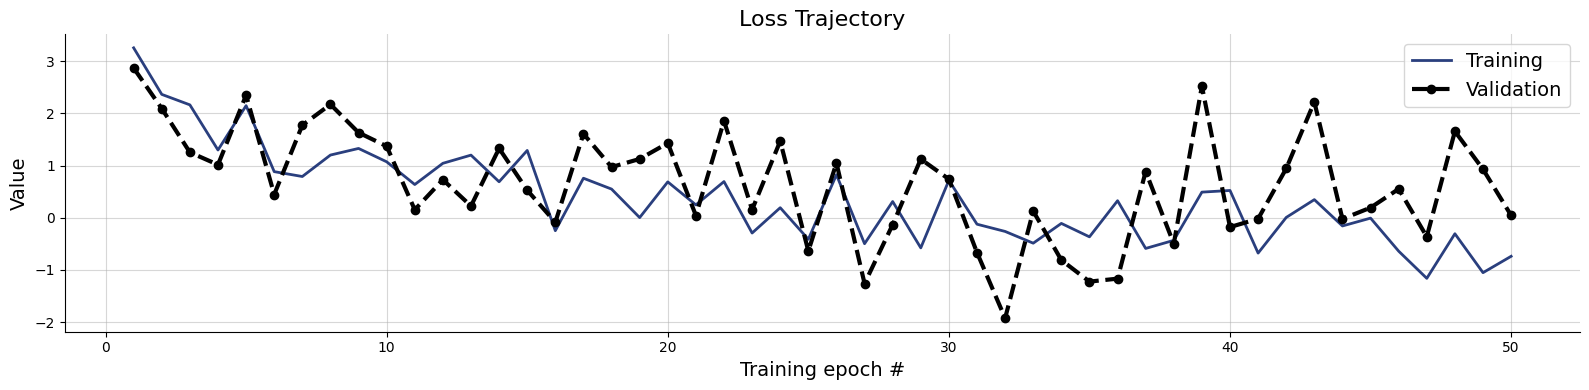

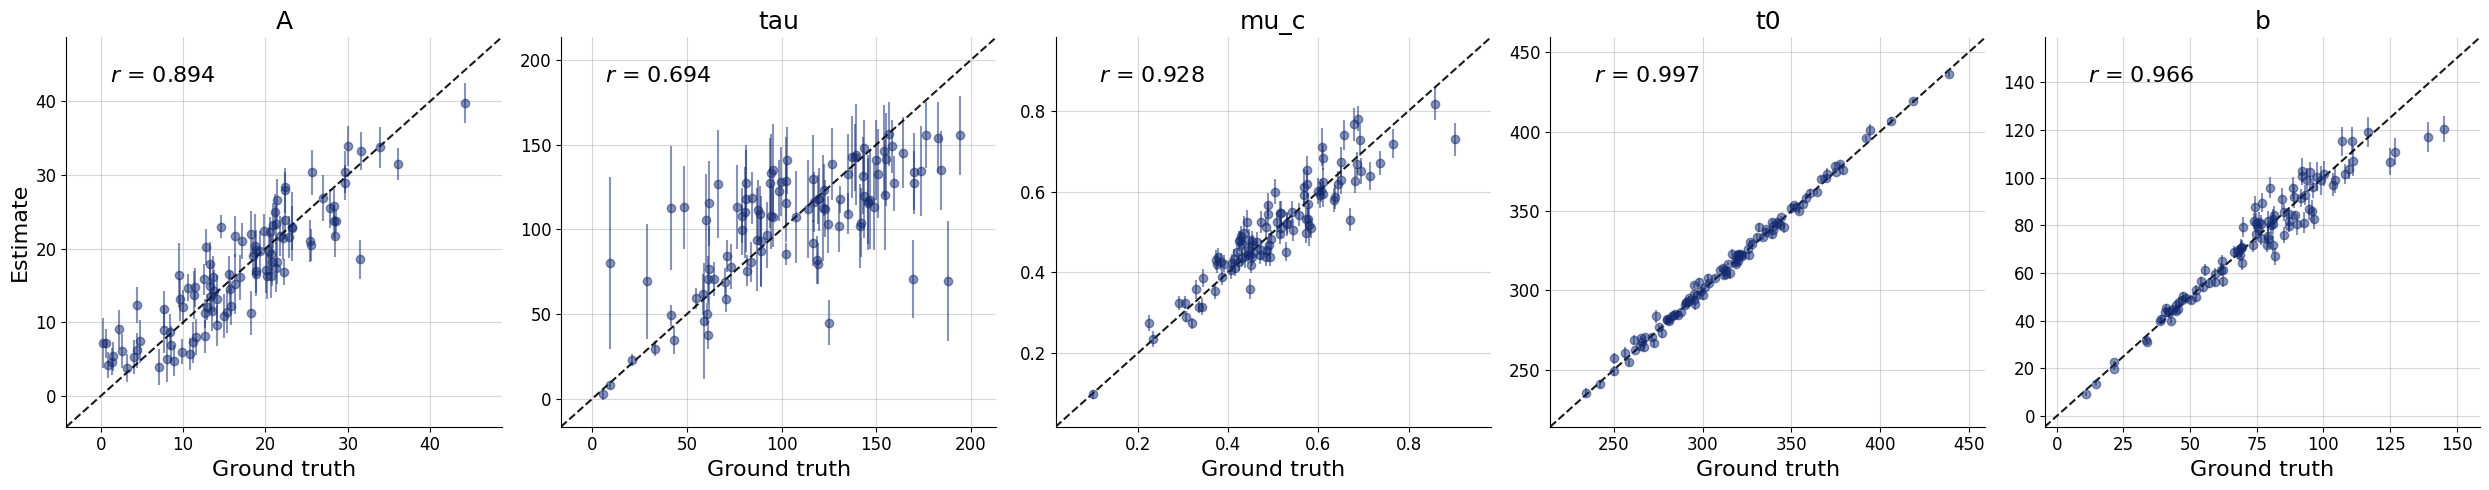

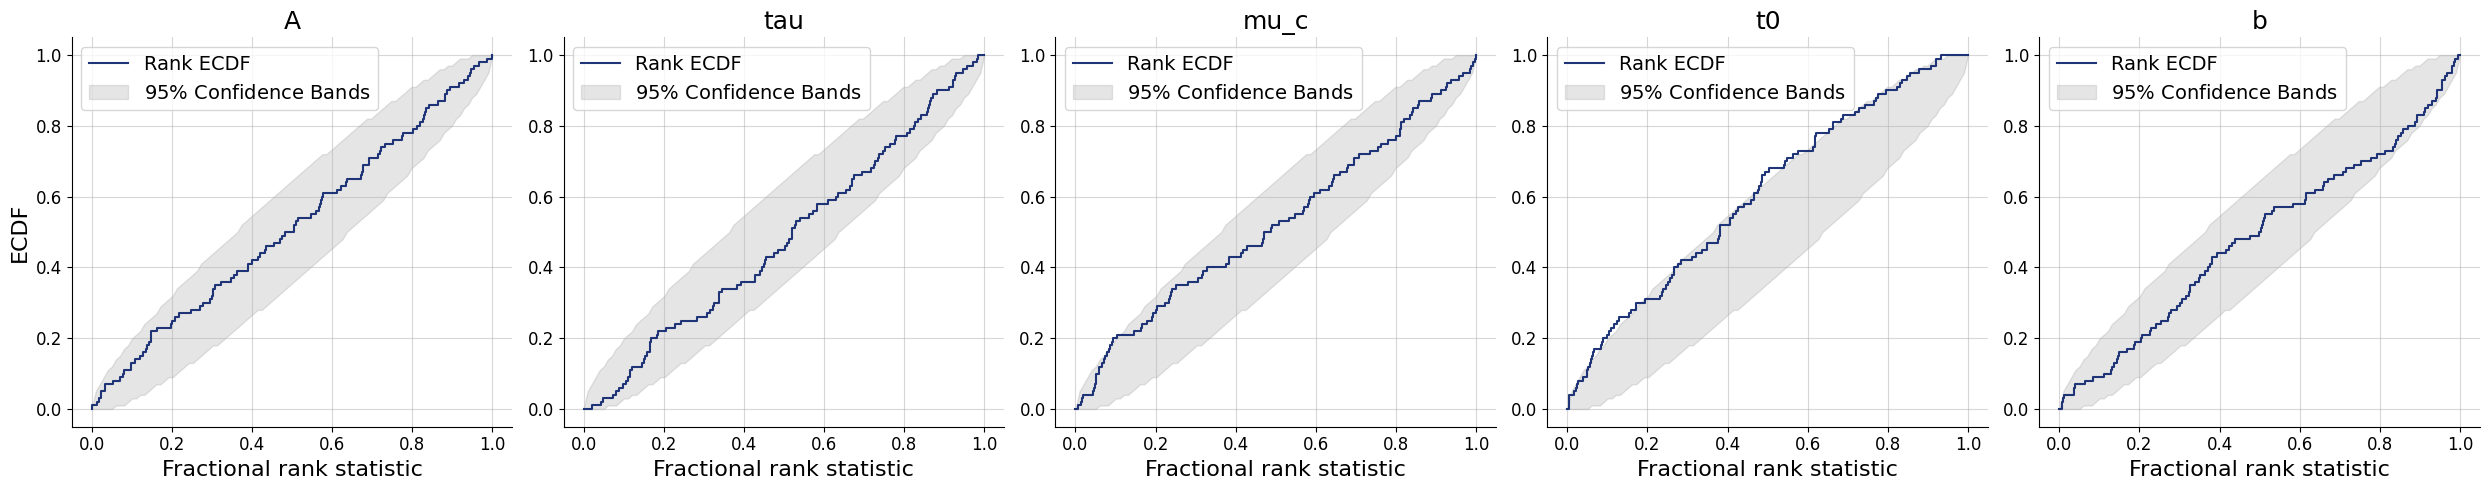

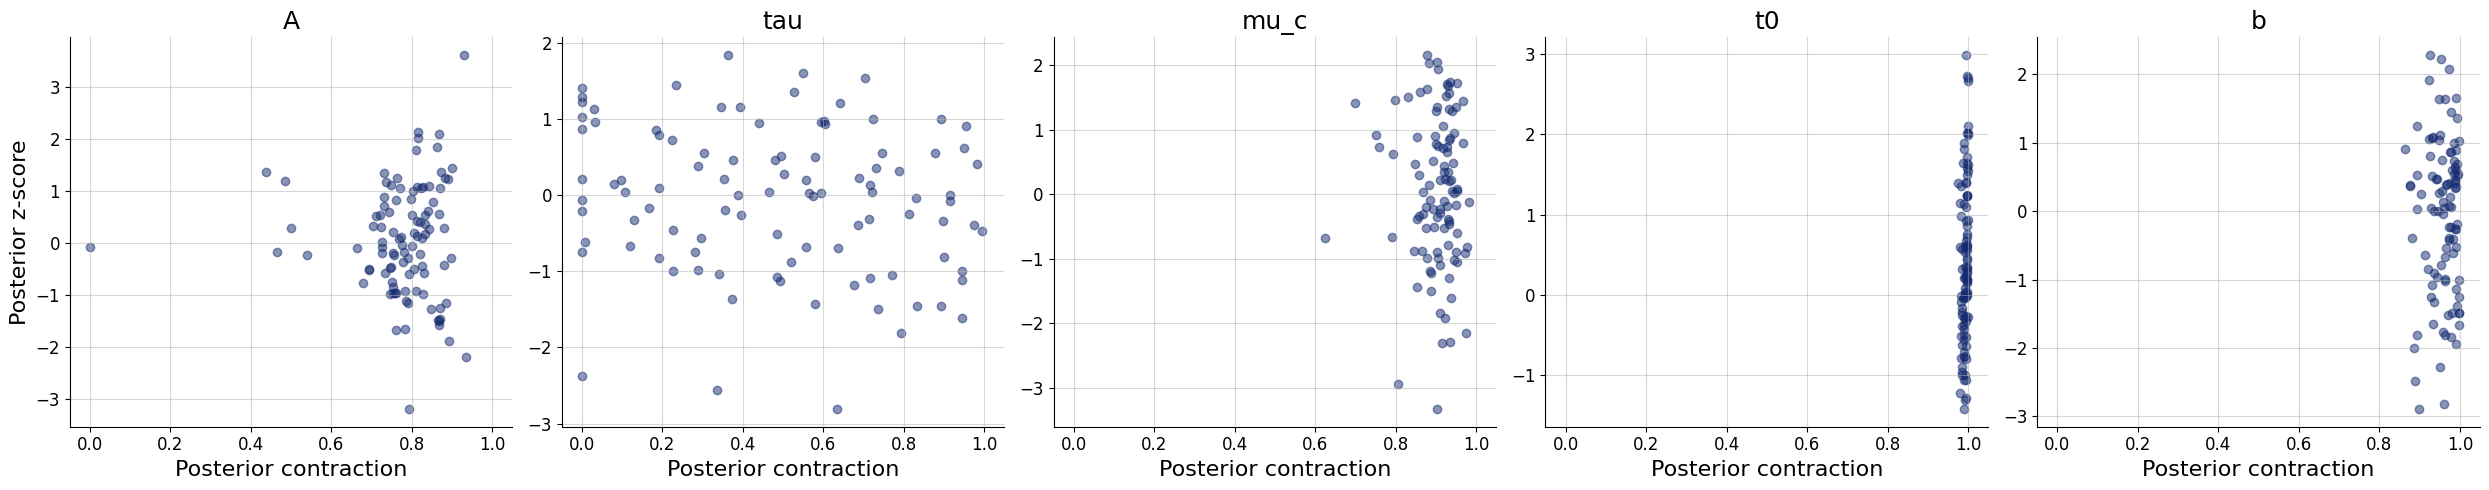

In [19]:
figs = workflow.plot_default_diagnostics(test_data=val_data)

In [20]:
table = workflow.compute_default_diagnostics(test_data=val_data)
table

,A,tau,mu_c,t0,b
NRMSE,0.128201,0.237923,0.080446,0.022781,0.064084
Posterior Contraction,0.792813,0.508439,0.915841,0.993922,0.964119
Calibration Error,0.016842,0.028684,0.060263,0.013421,0.057895


In [21]:
table = workflow.compute_custom_diagnostics(test_data=val_data)

TypeError: BasicWorkflow.compute_custom_diagnostics() missing 1 required positional argument: 'metrics'

## Custom Stuff

In [ ]:
approximator = keras.saving.load_model("../checkpoints/simons_crazy_net.keras")

/Users/simonschaefer/anaconda3/envs/bf_new/lib/python3.11/site-packages/keras/src/saving/serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)


In [23]:
samples = approximator.sample(conditions=val_data, num_samples=1000)

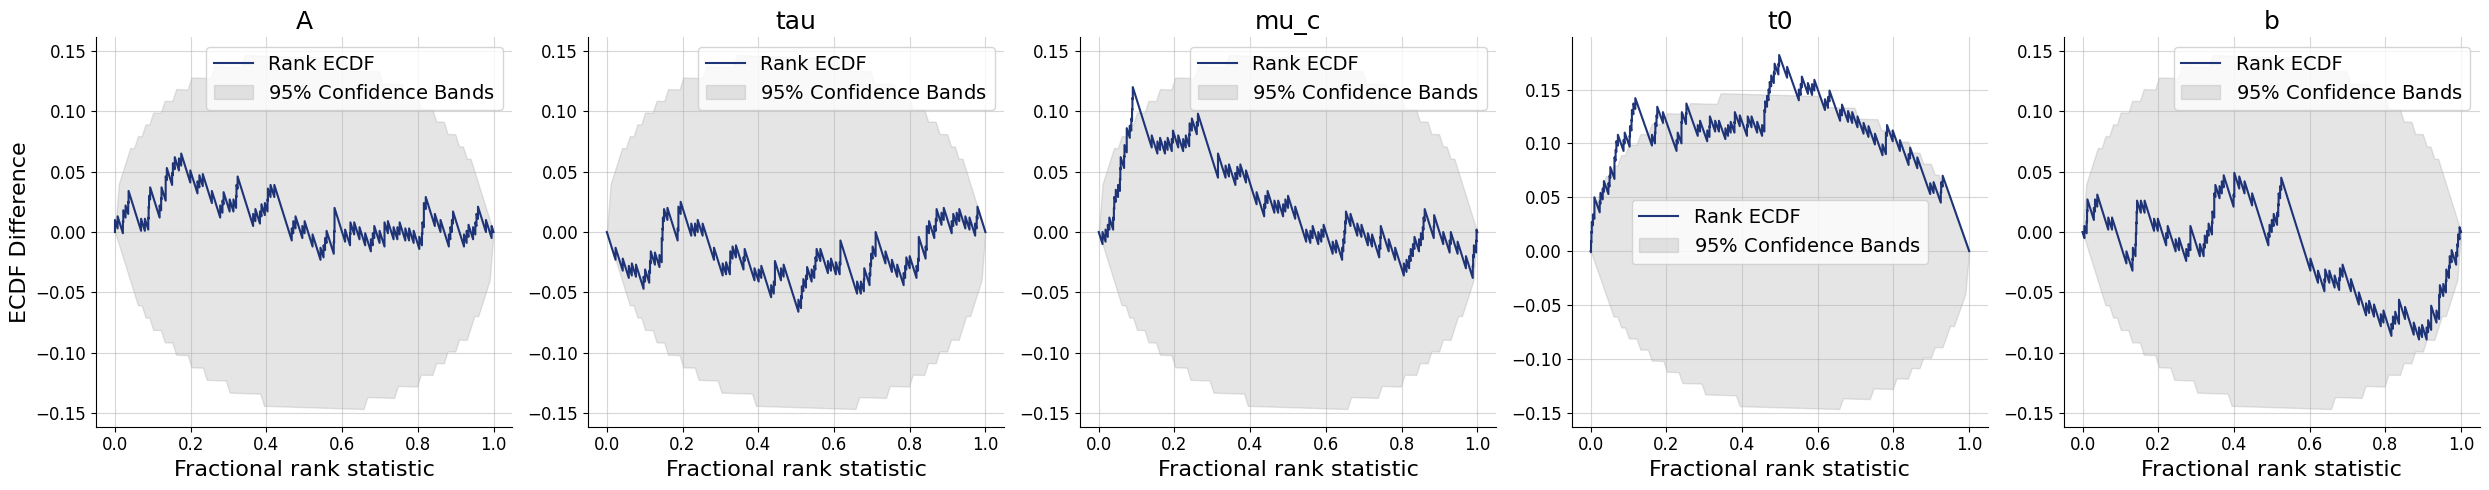

In [24]:
sbc = bf.diagnostics.plots.calibration_ecdf(samples, val_data, variable_keys=["A", "tau", "mu_c", "t0", "b"], difference=True)

## Real Data Inference

In [ ]:
#TODO

## Posterior Predictive Checks

In [ ]:
#TODO